In [1]:
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
arch = {'knl':(cm.Greens, 450,0.5,0.33),'skl':(cm.Greys,200,0.5,0.75),   'p100':(cm.Blues,  550,0.5,0.43),
       'v100':(cm.Purples,850,0.5,0.85), 'i5':(cm.Wistia,30,0.5,0.79),'gtx1060':(cm.Oranges,155,0.5,0.70)}
intens={1:0.8, 2:0.6, 4:0.4}
marker={2:'d', 3:'o', 4:'s',5:'p'}
#(hardware name, number of nodes)
filesD = {
        'knl_mpi1':('knl',1),
        'knl_mpi2':('knl',2), 'knl_mpi4':('knl',4),
        'skl_mpi1':('skl',1), 
        'skl_mpi2':('skl',2), 'skl_mpi4':('skl',4),
        'i5':('i5',1),
        'p100_mpi1':('p100',1), 
        'p100_mpi2':('p100',2), 'p100_mpi4':('p100',4),
        'v100_mpi1':('v100',1), 
        'v100_mpi2':('v100',2), 'v100_mpi4':('v100',4),
        'gtx1060':('gtx1060',1)
        }

files = odict(sorted(filesD.items(), key= lambda t : t[1][1]))
number=0
for k,v in files.items(): 
    if v[1]==1: number+=1


In [3]:
#(axpby,dot,dxdy)
latencies = odict()
latencies['scal'] = (1,0,0)
latencies['axpby'] = (1,0,0)
latencies['pointwiseDot'] = (1,0,0)
latencies['dot'] = (0,1,0)
latencies['dx'] = (0,0,1)
latencies['dy'] = (0,0,1)
latencies['arakawa'] = (3,0,6) # N = 9
latencies['cg'] = (6,2,6) # N = 13
latencies['avg']= (9,2,12) # N=23
memops = odict()
memops['scal']= (2,0,0)
memops['axpby']= (3,0,0)
memops['pointwiseDot']= (6,0,0)
memops['dot']= (0,2,0)
memops['dx']= (0,0,3)
memops['dy']= (0,0,3)
memops['arakawa'] = (16,0,18) # M = 34 -> M/N = 3.78
memops['cg'] = (20,4,18) # M = 42 -> M/N = 3.23
memops['avg'] = (36,4,36) # M = 76 -> M/N = 3.30

In [4]:
theo = pd.read_csv('performance.csv',delimiter=' ')
theo.set_index('arch',inplace=True)
theo.index.name = None
pd.set_option('display.float_format', lambda x: '%.2f' % x)
theo

,axpby_bw,axpby_bw_err,dot_bw,dot_bw_err,dxdy2_bw,dxdy2_bw_err,dxdy3_bw,dxdy3_bw_err,dxdy4_bw,dxdy4_bw_err,...,axpby_lat_dist,axpby_lat_dist_err,dot_lat_shared,dot_lat_shared_err,dot_lat_dist,dot_lat_dist_err,dxdy_lat_shared,dxdy_lat_shared_err,dxdy_lat_dist,dxdy_lat_dist_err
i5,29.99,0.19,9.31,0.04,27.79,2.97,29.12,2.84,25.58,1.49,...,nan,nan,4.76,0.23,nan,nan,0.00,1.44,nan,nan
gtx1060,157.05,0.06,26.50,0.10,130.63,0.40,111.23,1.11,83.82,13.83,...,nan,nan,92.06,8.70,nan,nan,0.00,0.82,nan,nan
skl,206.71,5.87,192.05,18.31,181.56,35.38,161.75,13.00,118.06,18.39,...,0.00,0.26,17.28,2.32,37.93,4.14,22.70,2.11,28.52,2.10
knl,393.15,22.19,141.36,6.63,239.04,17.02,172.69,26.80,126.04,18.59,...,9.16,0.09,54.83,1.79,119.59,5.14,9.93,0.70,52.67,3.72
p100,553.33,0.69,346.08,1.53,287.57,2.14,237.35,3.26,200.30,1.81,...,2.42,0.05,48.15,0.71,48.16,0.63,1.82,0.34,63.51,0.80
v100,848.36,0.67,593.35,2.15,801.91,16.97,712.07,19.24,649.44,15.38,...,2.30,0.11,33.95,1.15,34.73,0.56,3.11,0.16,66.63,1.22


In [5]:
#define conversion function 
def toString(x): 
    if pd.isnull(x) : return 'n/a'
    #string = '%.1f'% x
    string = '%d' %np.ceil(x)
    #if np.ceil(x)<100 : string = '0'+string
    if np.ceil(x)<10 : string = '0'+string
    return string

In [6]:
lines=[]
#now compute and plot the prediction 
archs = ['i5','gtx1060','skl','knl','p100','v100']
for k in archs : 
    line =[]
    for q,l in latencies.items():
        m = memops[q]
        M = m[0]+m[1]+m[2]
        for n in [2,3,4,5]:
            bw = [theo.loc[k,'axpby_bw'],theo.loc[k,'dot_bw'],theo.loc[k,'dxdy'+str(n)+'_bw']]
            err_bw = [theo.loc[k,'axpby_bw_err'],theo.loc[k,'dot_bw_err'],theo.loc[k,'dxdy'+str(n)+'_bw_err']]
            bandwidth = M/(m[0]/bw[0] + m[1]/bw[1] + m[2]/bw[2])
            err_bandwidth = bandwidth/(m[0]/bw[0] + m[1]/bw[1] + m[2]/bw[2])*np.sqrt(
                (m[0]/bw[0]**2*err_bw[0])**2 + (m[1]/bw[1]**2*err_bw[1])**2 + (m[2]/bw[2]**2*err_bw[2])**2  )
            line.append( toString( bandwidth)+" $\pm$ "+toString(err_bandwidth))
        L = l[0]+l[1]+l[2]
        for dist in ['shared','dist']:
            lat = [theo.loc[k,'axpby_lat_'+dist], theo.loc[k,'dot_lat_'+dist], theo.loc[k,'dxdy_lat_'+dist]]
            err_lat = [theo.loc[k,'axpby_lat_'+dist+'_err'], theo.loc[k,'dot_lat_'+dist+'_err'], theo.loc[k,'dxdy_lat_'+dist+'_err']]
            latency = ( l[0]*lat[0]+ l[1]* lat[1] + l[2]*lat[2])/L #in us
            err_latency = np.sqrt( (l[0]*err_lat[0])**2 + (l[1]*err_lat[1])**2 + (l[2]*err_lat[2])**2 )/L
            if (dist == 'dist') and ((k == 'i5') or (k=='gtx1060')):
                line.append(toString( None))
            else: line.append(toString( latency)+" $\pm$ "+toString(err_latency))
        #print(q,latency)

    lines.append(line)
index = archs
tuples=[]  
for p in latencies.keys():
    for q in ['B(P=2) [GB/s]','B(P=3) [GB/s]','B(P=4) [GB/s]','B(P=5) [GB/s]',
              '$T_{lat}(1)$ [$\mu$s]','$T_{lat}(4)$ [$\mu$s]']:
        tuples.append((p,q))
    

cols=pd.MultiIndex.from_tuples(tuples)

avg = pd.DataFrame(lines, index=index, columns=cols)
#avg.sort_values(by=('avg','B(P=2) [GB/s]'), inplace=True)
#avg.loc[:,('cg','size')]=(avg['cg']['P=3']/1e3*9/34
#                              )*avg['cg']['lat 4 [$\mu$s]']
pd.set_option('display.float_format', lambda x: '%.0f' % x)
#avg.loc['i5',('avg','$T_{lat}(4)$ [$\mu$s]')]='n/a'
#avg.loc['gtx1060',('avg','$T_{lat}(4)$ [$\mu$s]')]='n/a'
filename='avg.tex'
with open(filename, 'wb') as f:
    f.write(bytes(avg['avg'].to_latex(
        escape=False,column_format='lp{1.5cm}p{1.5cm}p{1.5cm}p{1.5cm}p{1.2cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
avg['avg']

,B(P=2) [GB/s],B(P=3) [GB/s],B(P=4) [GB/s],B(P=5) [GB/s],$T_{lat}(1)$ [$\mu$s],$T_{lat}(4)$ [$\mu$s]
i5,26 $\pm$ 02,27 $\pm$ 02,26 $\pm$ 01,23 $\pm$ 02,01 $\pm$ 01,n/a
gtx1060,116 $\pm$ 01,108 $\pm$ 01,94 $\pm$ 09,85 $\pm$ 12,09 $\pm$ 01,n/a
skl,194 $\pm$ 20,183 $\pm$ 09,153 $\pm$ 15,147 $\pm$ 07,14 $\pm$ 02,19 $\pm$ 02
knl,281 $\pm$ 13,232 $\pm$ 24,188 $\pm$ 20,160 $\pm$ 18,13 $\pm$ 01,42 $\pm$ 02
p100,377 $\pm$ 02,333 $\pm$ 04,297 $\pm$ 02,259 $\pm$ 17,06 $\pm$ 01,39 $\pm$ 01
v100,808 $\pm$ 09,763 $\pm$ 11,727 $\pm$ 10,653 $\pm$ 35,06 $\pm$ 01,39 $\pm$ 01


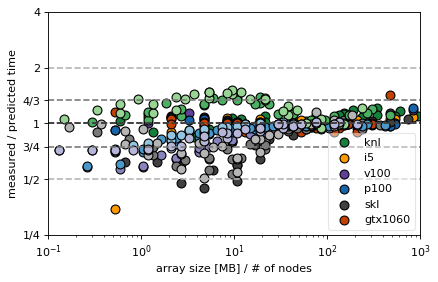

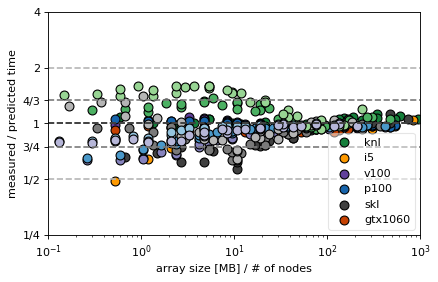

In [7]:
del latencies['avg']
del memops['avg']
#now compute and plot the prediction 
for n in ['arakawa','cg'] :#latencies.keys():
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 80, facecolor='w', edgecolor='k')
    xs = np.array([0.1,1000])
    ys = np.array([1.0,1.0])
    for frac in [1.0,4/3,8/4]:
        plt.plot(xs,frac*ys,ls='--',color=cm.Greys(0.8/frac))
        plt.plot(xs,1/frac*ys,ls='--',color=cm.Greys(0.8/frac))
        
    for f, v in files.items() :#{'knl_mpi2':('knl',2)}.items():
        df=pd.read_csv('benchmark_'+f+'.csv', delimiter=' ')
        #add size and get rid of non-relevant columns
        df.insert(0,'size', 8*df['n']*df['n']*df['Nx']*df['Ny']/1e6/v[1])
        dfr = df[['n','Nx','Ny','size']+list(memops.keys())]
        #compute mean and standard derivation of 'same' groups 
        dfr=dfr.groupby(['n', 'Nx','Ny','size']).mean()
        dfr=dfr.reset_index(level=['n','Nx','Ny','size'])

        dfr['FirstLevel']='measured'
        dfr.columns=pd.MultiIndex.from_product([dfr.columns,['measured']])
        del dfr['FirstLevel']
        
        dfr['dxdy_bw'] = dfr.apply( 
            lambda row: theo.loc[v[0],'dxdy'+str(row['n','measured'].astype(int))+'_bw'], axis=1)

        dxdystring = 'dxdy_lat_shared'
        dotstring = 'dot_lat_shared'
        if v[1] > 1 : 
            dxdystring = 'dxdy_lat_dist'
            dotstrint = 'dot_lat_dist'
        for q,l in latencies.items():
            m = memops[q]
            dfr.loc[:,(q,'predicted')] = (
                                    ( l[0]*theo.loc[v[0],'axpby_lat_shared']+
                                      l[1]*theo.loc[v[0],dotstring] +
                                      l[2]*theo.loc[v[0],dxdystring]
                                    )*1e-6+
                                    (m[0]/theo.loc[v[0],'axpby_bw'] + m[1]/theo.loc[v[0],'dot_bw'] + m[2]/dfr['dxdy_bw',''])
                                       *dfr[('size','measured')]/1000)
            dfr.loc[:,(q,'meas/pred')]=dfr[(q,'measured')]/dfr[(q,'predicted')]

        toPlot = dfr[n].join(dfr[('size')],rsuffix='_size')
        toPlot.plot(kind='scatter',ax=ax,color=arch[v[0]][0](intens[v[1]]),edgecolors='k',
                     x=('measured_size'), y='meas/pred',label=v[0],s=64)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[0:number]; labels = labels[0:number]

    #plt.plot(xs,ys)

    
    plt.legend(handles, labels, loc='lower right',
               scatterpoints=1,fontsize='medium',framealpha=0.5)
    plt.xscale('log')
    plt.xlim(xs[0],xs[1])
    #plt.xlabel('measured time in s')
    plt.xlabel('array size [MB] / # of nodes')
    plt.ylabel('measured / predicted time')
    plt.yscale('log', subsy=[0])#log scale, turn minor ticks off
    plt.ylim(1/3,3)
    plt.yticks([1/4,0.5,0.75,1,1.33,2,4],['1/4','1/2','3/4',1,'4/3',2,4])
    #plt.title(n)
    plt.savefig(n+'.pdf',bbox_inches='tight')

### Observations
- plots show deviations from the predicted timing
- the goal of the discussion is to prove that the time formula is correct because then performance can be discussed analytically and makes "scaling" plots somewhat obsolete
- there seems to be a systematic overestimation of the knl MPI scaling (is this the fault of the implemenation? What is wrong there?)
- skl and i5 for small sizes are mostly faster than predicted because cache effects are not included in the model
- there seems to a drop in efficiency in GPUs when the problem size nears the full size of the GPU memory (last single node points in GTX, P100 and V100)